In [1]:
!pip install opencv-python numpy


[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import cv2
import numpy as np

In [3]:
# https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt
FACE_PROTO = "weights/deploy.prototxt.txt"
# https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20180205_fp16/res10_300x300_ssd_iter_140000_fp16.caffemodel
FACE_MODEL = "weights/res10_300x300_ssd_iter_140000_fp16.caffemodel"
# The gender model architecture
# https://drive.google.com/open?id=1W_moLzMlGiELyPxWiYQJ9KFaXroQ_NFQ
GENDER_MODEL = 'weights/deploy_gender.prototxt'
# The gender model pre-trained weights
# https://drive.google.com/open?id=1AW3WduLk1haTVAxHOkVS_BEzel1WXQHP
GENDER_PROTO = 'weights/gender_net.caffemodel'
# Each Caffe Model impose the shape of the input image also image preprocessing is required like mean
# substraction to eliminate the effect of illunination changes
MODEL_MEAN_VALUES = (78.4263377603, 87.7689143744, 114.895847746)
# Represent the gender classes
GENDER_LIST = ['Male', 'Female']
# The model architecture
# download from: https://drive.google.com/open?id=1kiusFljZc9QfcIYdU2s7xrtWHTraHwmW
AGE_MODEL = 'weights/deploy_age.prototxt'
# The model pre-trained weights
# download from: https://drive.google.com/open?id=1kWv0AjxGSN0g31OeJa02eBGM0R_jcjIl
AGE_PROTO = 'weights/age_net.caffemodel'
# Represent the 8 age classes of this CNN probability layer
AGE_INTERVALS = ['(0, 2)', '(4, 6)', '(8, 12)', '(15, 20)',
                 '(25, 32)', '(38, 43)', '(48, 53)', '(60, 100)']

In [4]:
# Initialize frame size
frame_width = 1280
frame_height = 720
# load face Caffe model
face_net = cv2.dnn.readNetFromCaffe(FACE_PROTO, FACE_MODEL)
# Load age prediction model
age_net = cv2.dnn.readNetFromCaffe(AGE_MODEL, AGE_PROTO)
# Load gender prediction model
gender_net = cv2.dnn.readNetFromCaffe(GENDER_MODEL, GENDER_PROTO)

In [5]:
def get_faces(frame, confidence_threshold=0.5):
    # convert the frame into a blob to be ready for NN input
    blob = cv2.dnn.blobFromImage(frame, 1.0, (300, 300), (104, 177.0, 123.0))
    # set the image as input to the NN
    face_net.setInput(blob)
    # perform inference and get predictions
    output = np.squeeze(face_net.forward())
    # initialize the result list
    faces = []
    # Loop over the faces detected
    for i in range(output.shape[0]):
        confidence = output[i, 2]
        if confidence > confidence_threshold:
            box = output[i, 3:7] * \
                np.array([frame.shape[1], frame.shape[0],
                         frame.shape[1], frame.shape[0]])
            # convert to integers
            start_x, start_y, end_x, end_y = box.astype(np.int)
            # widen the box a little
            start_x, start_y, end_x, end_y = start_x - \
                10, start_y - 10, end_x + 10, end_y + 10
            start_x = 0 if start_x < 0 else start_x
            start_y = 0 if start_y < 0 else start_y
            end_x = 0 if end_x < 0 else end_x
            end_y = 0 if end_y < 0 else end_y
            # append to our list
            faces.append((start_x, start_y, end_x, end_y))
    return faces

In [6]:
# from: https://stackoverflow.com/questions/44650888/resize-an-image-without-distortion-opencv
def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]
    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image
    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)
    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))
    # resize the image
    return cv2.resize(image, dim, interpolation = inter)

In [7]:
def get_gender_predictions(face_img):
    blob = cv2.dnn.blobFromImage(
        image=face_img, scalefactor=1.0, size=(227, 227),
        mean=MODEL_MEAN_VALUES, swapRB=False, crop=False
    )
    gender_net.setInput(blob)
    return gender_net.forward()


def get_age_predictions(face_img):
    blob = cv2.dnn.blobFromImage(
        image=face_img, scalefactor=1.0, size=(227, 227),
        mean=MODEL_MEAN_VALUES, swapRB=False
    )
    age_net.setInput(blob)
    return age_net.forward()

In [8]:
def predict_age_and_gender(input_path: str):
    """Predict the gender of the faces showing in the image"""
    # Initialize frame size
    # frame_width = 1280
    # frame_height = 720
    # Read Input Image
    img = cv2.imread(input_path)
    # resize the image, uncomment if you want to resize the image
    # img = cv2.resize(img, (frame_width, frame_height))
    # Take a copy of the initial image and resize it
    frame = img.copy()
    if frame.shape[1] > frame_width:
        frame = image_resize(frame, width=frame_width)
    # predict the faces
    faces = get_faces(frame)
    # Loop over the faces detected
    # for idx, face in enumerate(faces):
    for i, (start_x, start_y, end_x, end_y) in enumerate(faces):
        face_img = frame[start_y: end_y, start_x: end_x]
        age_preds = get_age_predictions(face_img)
        gender_preds = get_gender_predictions(face_img)
        i = gender_preds[0].argmax()
        gender = GENDER_LIST[i]
        gender_confidence_score = gender_preds[0][i]
        i = age_preds[0].argmax()
        age = AGE_INTERVALS[i]
        age_confidence_score = age_preds[0][i]
        # Draw the box
        label = f"{gender}-{gender_confidence_score*100:.1f}%, {age}-{age_confidence_score*100:.1f}%"
        # label = "{}-{:.2f}%".format(gender, gender_confidence_score*100)
        print(label)
        yPos = start_y - 15
        while yPos < 15:
            yPos += 15
        box_color = (255, 0, 0) if gender == "Male" else (147, 20, 255)
        cv2.rectangle(frame, (start_x, start_y), (end_x, end_y), box_color, 2)
        # Label processed image
        font_scale = 0.54
        cv2.putText(frame, label, (start_x, yPos),
                    cv2.FONT_HERSHEY_SIMPLEX, font_scale, box_color, 2)

        # Display processed image
    display_img("Gender Estimator", frame)
    # uncomment if you want to save the image
    cv2.imwrite("output.jpg", frame)
    # Cleanup
    cv2.destroyAllWindows()

In [9]:
input_path = "C:/Users/127ri/Desktop/MBA\CourseWork\Fall\Data Analytics\course_files_export (1)\Project\Twitter Pics\RDJ.png"

In [10]:
input_path = "C:/Users/127ri/Desktop/MSBA/CourseWork/Fall/Data Analytics/course_files_export (1)/Project/Twitter Pics/Trump2020/_addycat.png"

In [11]:
img = cv2.imread(input_path)
# resize the image, uncomment if you want to resize the image
# img = cv2.resize(img, (frame_width, frame_height))
# Take a copy of the initial image and resize it
frame = img.copy()
if frame.shape[1] > frame_width:
    frame = image_resize(frame, width=frame_width)

faces = get_faces(frame)

In [12]:
img

array([[[0, 0, 5],
        [1, 0, 2],
        [6, 1, 0],
        ...,
        [0, 3, 0],
        [1, 0, 4],
        [3, 0, 5]],

       [[0, 0, 5],
        [1, 0, 2],
        [6, 1, 0],
        ...,
        [0, 3, 0],
        [1, 0, 4],
        [3, 0, 5]],

       [[0, 0, 5],
        [1, 0, 2],
        [6, 1, 0],
        ...,
        [0, 3, 0],
        [1, 0, 4],
        [3, 0, 5]],

       ...,

       [[0, 0, 5],
        [1, 0, 2],
        [6, 1, 0],
        ...,
        [8, 1, 0],
        [3, 0, 4],
        [1, 0, 5]],

       [[0, 0, 5],
        [1, 0, 2],
        [6, 1, 0],
        ...,
        [8, 1, 0],
        [3, 0, 4],
        [1, 0, 5]],

       [[0, 0, 5],
        [1, 0, 2],
        [6, 1, 0],
        ...,
        [8, 1, 0],
        [3, 0, 4],
        [1, 0, 5]]], dtype=uint8)

In [13]:
for i, (start_x, start_y, end_x, end_y) in enumerate(faces):
    face_img = frame[start_y: end_y, start_x: end_x]
    age_preds = get_age_predictions(face_img)
    gender_preds = get_gender_predictions(face_img)
    i = gender_preds[0].argmax()
    gender = GENDER_LIST[i]
    gender_confidence_score = gender_preds[0][i]
    i = age_preds[0].argmax()
    age = AGE_INTERVALS[i]
    age_confidence_score = age_preds[0][i]

In [14]:
gender_confidence_score

NameError: name 'gender_confidence_score' is not defined

In [ ]:
gender

In [ ]:
age

In [15]:
import pandas as pd

In [16]:
data1 = pd.read_csv('biden_20_geotagged.csv')

In [17]:
data2 = pd.read_csv('trump_20_geotagged.csv')

In [18]:
data3 = pd.read_csv('trump_16_geotagged.csv')

In [19]:
data4 = pd.read_csv('hillary_16_geotagged.csv')

In [20]:
users, users1, users2, users3, users4 = [], [], [], [], []

In [21]:
users1 = data1['Username'].unique()
users2 = data2['Username'].unique()
users3 = data3['Username'].unique()
users4 = data4['Username'].unique()

users.extend(users1)
users.extend(users2)
users.extend(users3)
users.extend(users4)

users

['LiftingPhoenixx',
 'ChallenWStewart',
 'AustinGaminz',
 'james_wendeln',
 'Deerslayer2013',
 'ncellar',
 'Anthonymanna3',
 'codeeznutz',
 'JOSELUISDIEPPA',
 'patslife1984',
 'ArielMiqueas',
 'fullpapii',
 'markskon',
 'ElaineSensiper',
 'BINLE56',
 'francisco_zp',
 'dasc97',
 'jonathan_blck',
 'AnnaForFlorida',
 'karopi089',
 'twittipolitti',
 'NewsGuyGreg',
 'AlexShelnutt',
 'Comemigirano',
 'dandonttweet',
 'EbonyLatina111',
 'bjoewolf',
 'Hector270964',
 'JohnnyDiggz',
 'ricktechrep',
 'VanDuynomite',
 'bpm_flwx',
 'WPHSMarketing',
 'loonewolf24',
 'ecocentrism1',
 'HaroldNOKumar',
 'HurricaneDebs',
 'dunnclin2009',
 'Princez2593',
 'NowImNothing_',
 'GingerMundy',
 'rbenitez825',
 'TNUN',
 'TheMcFaddenShow',
 'JDCocchiarella',
 'KateChief',
 'tide_pauds',
 'ClarenceDayPSU',
 'donovan432004',
 'stormscomming',
 'TriviumPaolo',
 'orlandoribbons',
 'DavidMonty2010',
 'DaddCat',
 'smoore1966',
 'flowsie_',
 'jmrivera34',
 'GlamMe2',
 'RobertHurbanis',
 'zacstack',
 'FNFlirtyDoc',
 'J

In [23]:
users = res

In [24]:
len(users)

43221

In [25]:
user_no_pic_saved = []

In [26]:
result = []

In [15]:
for n, user in enumerate(users):
    if n>100:
        print(n, " users done")
        break
    input_path = "C:/Users/127ri/Desktop/MSBA/CourseWork/Fall/Data Analytics/course_files_export (1)/Project/Twitter Pics/Trump2020/"+user+".png"
    
    try:
        img = cv2.imread(input_path)
        frame = img.copy()
        if frame.shape[1] > frame_width:
            frame = image_resize(frame, width=frame_width)

        faces = get_faces(frame)

        for i, (start_x, start_y, end_x, end_y) in enumerate(faces):
            face_img = frame[start_y: end_y, start_x: end_x]
            age_preds = get_age_predictions(face_img)
            gender_preds = get_gender_predictions(face_img)
            i = gender_preds[0].argmax()
            gender = GENDER_LIST[i]
            gender_confidence_score = gender_preds[0][i]
            i = age_preds[0].argmax()
            age = AGE_INTERVALS[i]
            age_confidence_score = age_preds[0][i]
            result.append((user,gender,gender_confidence_score,age,age_confidence_score))
    except:
        user_no_pic_saved.append(user)
        continue
    # resize the image, uncomment if you want to resize the image
    # img = cv2.resize(img, (frame_width, frame_height))
    # Take a copy of the initial image and resize it
    

C:\Users\127ri\AppData\Local\Temp\ipykernel_6304\1631374886.py:18: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  start_x, start_y, end_x, end_y = box.astype(np.int)


101  users done


In [13]:
img = cv2.imread(input_path)

img

NameError: name 'cv2' is not defined

In [12]:
input_path

'C:/Users/127ri/Desktop/MSBA/CourseWork/Fall/Data Analytics/course_files_export (1)/Project/Twitter Pics/Trump2020/ElizabethMReyna.png'

In [33]:
user_no_pic_saved

['MNnewbie']

In [32]:
df = pd.DataFrame(result, columns = ['Username','Gender','Gender_Conf','Age','Age_Conf'])

df

,Username,Gender,Gender_Conf,Age,Age_Conf
0,_bad_ashh,Female,0.999762,"(25, 32)",0.646207
1,8Crawdaddy3,Female,0.999599,"(15, 20)",0.987500
2,8Crawdaddy3,Male,0.999610,"(25, 32)",0.972224
3,PatHowley,Male,0.999998,"(8, 12)",0.785876
4,PatHowley,Male,0.802773,"(38, 43)",0.387532
...,...,...,...,...,...
91,CamdenArnold,Male,0.998449,"(25, 32)",0.730644
92,CamdenArnold,Male,0.912988,"(48, 53)",0.773243
93,givahn_17,Female,0.899470,"(8, 12)",0.884396
94,givahn_17,Male,0.997668,"(4, 6)",0.961524


In [35]:
user_array = df['Username'].unique()

In [36]:
len(user_array)

73

In [52]:
df[df['Gender_Conf']>0.8].count()

Username       88
Gender         88
Gender_Conf    88
Age            88
Age_Conf       88
dtype: int64

In [16]:
user_no_pic_saved = []

In [17]:
result = []

In [27]:
for n, user in enumerate(users):
    #if n>100:
    #    print(n, " users done")
    #    break
    input_path = "C:/Users/127ri/Desktop/MSBA/CourseWork/Fall/Data Analytics/course_files_export (1)/Project/Twitter Pics/All/"+user+".png"
    
    try:
        img = cv2.imread(input_path)
        frame = img.copy()
        if frame.shape[1] > frame_width:
            frame = image_resize(frame, width=frame_width)

        faces = get_faces(frame)

        for i, (start_x, start_y, end_x, end_y) in enumerate(faces):
            face_img = frame[start_y: end_y, start_x: end_x]
            age_preds = get_age_predictions(face_img)
            gender_preds = get_gender_predictions(face_img)
            i = gender_preds[0].argmax()
            gender = GENDER_LIST[i]
            gender_confidence_score = gender_preds[0][i]
            i = age_preds[0].argmax()
            age = AGE_INTERVALS[i]
            age_confidence_score = age_preds[0][i]
            result.append((user,gender,gender_confidence_score,age,age_confidence_score))
    except:
        user_no_pic_saved.append(user)
        continue
    # resize the image, uncomment if you want to resize the image
    # img = cv2.resize(img, (frame_width, frame_height))
    # Take a copy of the initial image and resize it
    

C:\Users\127ri\AppData\Local\Temp\ipykernel_22232\1631374886.py:18: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  start_x, start_y, end_x, end_y = box.astype(np.int)


In [28]:
df = pd.DataFrame(result, columns = ['Username','Gender','Gender_Conf','Age','Age_Conf'])

df.head(1000)

,Username,Gender,Gender_Conf,Age,Age_Conf
0,OriginalJMG,Female,0.883567,"(25, 32)",0.519185
1,OriginalJMG,Male,0.816933,"(25, 32)",0.933475
2,toriki44,Female,0.948483,"(38, 43)",0.761155
3,DesSchnell,Female,0.901167,"(25, 32)",0.941668
4,DesSchnell,Male,0.963254,"(25, 32)",0.977782
...,...,...,...,...,...
995,mikebentle,Male,0.724531,"(60, 100)",0.501296
996,mikebentle,Female,0.999502,"(60, 100)",0.564541
997,LaneLane15,Male,0.875271,"(8, 12)",0.758389
998,doublesmoaked,Male,0.997756,"(8, 12)",0.749764


In [35]:
df.to_csv('Twitter_demographics.csv')

In [29]:
user_array = df['Username'].unique()

In [30]:
len(user_array)

30853

In [31]:
df[df['Gender_Conf']>0.8].count()

Username       33090
Gender         33090
Gender_Conf    33090
Age            33090
Age_Conf       33090
dtype: int64

In [32]:
len(df['Username'])

37269

In [33]:
len(user_no_pic_saved)

1616

In [34]:
len(users)

43221

In [71]:
df[df['Username']=='_ABOwens']

,Username,Gender,Gender_Conf,Age,Age_Conf


In [72]:
user_no_pic_saved

['DomD72',
 'lunchboxhero_4',
 'SpeakinTruthful',
 'MECCAGLOBAL',
 'swaffordnichol1',
 'whatsydney',
 'JGosnellNews',
 'brimanning',
 'DevarriusM',
 'ben_deeznutz',
 'drejitsu316',
 'jassribasuxxx',
 'jassmariexo',
 'J_LindsEcho',
 'BarefootYinzer',
 'T_Leenk44',
 'JaysonZorn',
 'CommonCauseWI',
 'CGillyNC',
 'annammxix',
 '2jayyyzz_',
 'Jocelynrvera',
 'kreeger',
 'prodadsbod',
 'mikeebboy',
 'jtTiso',
 'alrxahxp',
 'HappyLeroux',
 'JASchmidtEsq',
 'KyleAlbert95',
 'VersaceWizard_',
 'TakkoAM',
 'JanaGiddings',
 'Spook_Matt',
 'notskinnyortall',
 'QuanoMono',
 'TeamDanteeeee',
 'chase_carnzie',
 'ClaudiaPouravel',
 'ShaneSmithMedia',
 'Gingersnap1010',
 'abbyshepp',
 '12k_poppa',
 'odeehall',
 'MasonSmith4L',
 'EvagDivaG',
 'TheSupertight1',
 'b_a_b_01',
 'SharonLutz6',
 'boyd_mccamish',
 'Kallistadenton',
 'isa_G01',
 'cwipking12',
 'trecoult',
 'sam_htun',
 'greeneyed_irish',
 'jcastxiv',
 'PatShafferWV',
 'crazy_N28',
 'MiztyDon',
 'dia_IVXXX',
 'BeeNass_',
 'siddfrmiceage',
 'fath

In [73]:
len(user_no_pic_saved)

1616

In [22]:
res = [*set(users)]

In [57]:
len(res)

43221

In [77]:
df.dtypes

Username        object
Gender          object
Gender_Conf    float64
Age             object
Age_Conf       float64
Age_Tuple       object
dtype: object

In [97]:
import re
import math

In [100]:
df['Approx_Age'] = df['Age'].apply(lambda x: re.sub('\(|\)','',x)).str.split(',').apply(lambda x: round((int(x[0])+int(x[1]))/2,1))

In [101]:
df.head()

,Username,Gender,Gender_Conf,Age,Age_Conf,Age_Tuple,Approx_Age
0,LanceFischel5,Male,0.999923,"(15, 20)",0.988318,"[(15, 20)]",17.5
1,orelaxshelby,Female,0.998359,"(25, 32)",0.994030,"[(25, 32)]",28.5
2,refisjeff,Male,0.999942,"(38, 43)",0.962103,"[(38, 43)]",40.5
3,karend44,Female,0.960620,"(25, 32)",0.658544,"[(25, 32)]",28.5
4,ca020353,Male,0.999393,"(25, 32)",0.335129,"[(25, 32)]",28.5


In [129]:
df['Gender'].value_counts()

Male      22675
Female    14594
Name: Gender, dtype: int64

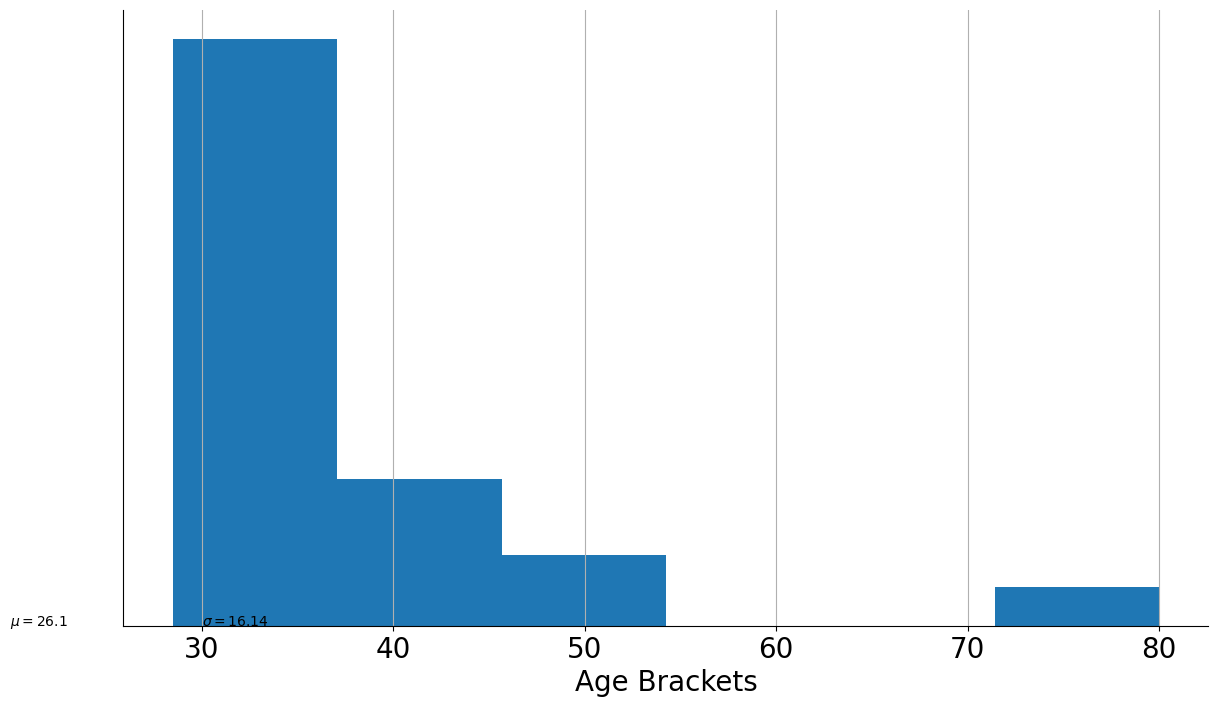

In [126]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14,8))

df[df['Approx_Age']>18].Approx_Age.hist(bins=6)

plt.xticks(fontsize=20)
plt.yticks([])

plt.xlabel('Age Brackets', fontsize=20)

plt.text(20, 2, f'$\\mu = {round(df.Approx_Age.mean(),2)}$', fontsize=10)
plt.text(30, 3, f'$\\sigma = {round(df.Approx_Age.std(),2)}$', fontsize=10)

sns.despine()
plt.show()

In [ ]:
df[df['Approx_Age']<18]

In [118]:
df[df['Approx_Age']<15]

,Username,Gender,Gender_Conf,Age,Age_Conf,Age_Tuple,Approx_Age
8,ZenchukMatthew,Male,0.591361,"(8, 12)",0.914666,"[(8, 12)]",10.0
12,gcardenas03,Male,0.751613,"(4, 6)",0.378103,"[(4, 6)]",5.0
18,Rustbelt49,Female,0.989626,"(8, 12)",0.745789,"[(8, 12)]",10.0
21,Litass_taz,Male,0.999998,"(8, 12)",0.854901,"[(8, 12)]",10.0
25,shelly_krafft,Male,0.880146,"(4, 6)",0.678149,"[(4, 6)]",5.0
...,...,...,...,...,...,...,...
37244,CitizenKarl,Male,0.999996,"(8, 12)",0.921557,"[(8, 12)]",10.0
37247,IvonnCardenas,Male,0.506672,"(4, 6)",0.878745,"[(4, 6)]",5.0
37251,nightwingsson,Female,0.756176,"(4, 6)",0.974362,"[(4, 6)]",5.0
37260,allienikkkol,Female,0.984090,"(8, 12)",0.649021,"[(8, 12)]",10.0


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14,8))

df_se.price_per_sqft.hist(bins=20)

plt.xticks(fontsize=20)
plt.yticks([])

plt.xlabel('Price per Square Foot', fontsize=20)

plt.text(2030, 160, f'$\\mu = {round(df_se.price_per_sqft.mean(),2)}$', fontsize=20)
plt.text(2030, 150, f'$\\sigma = {round(df_se.price_per_sqft.std(),2)}$', fontsize=20)

sns.despine()
plt.show()